# Notebook for the development of the model to power the face detection

### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import torch
from torchvision.datasets import WIDERFace
from collections import defaultdict
import os

### Constants

In [8]:
ROOT = "/content/" # Change to your root directory

### Download Data

In [2]:
WIDERFace(root="", download=True)

Downloading...
From (original): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
From (redirected): https://drive.usercontent.google.com/download?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M&confirm=t&uuid=98ab4f54-2264-425b-9719-be8088116782
To: /content/widerface/WIDER_train.zip
100%|██████████| 1.47G/1.47G [00:25<00:00, 57.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q
From (redirected): https://drive.usercontent.google.com/download?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q&confirm=t&uuid=22398f69-d90b-4842-a13d-8494d1d91aee
To: /content/widerface/WIDER_val.zip
100%|██████████| 363M/363M [00:07<00:00, 48.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T
From (redirected): https://drive.usercontent.google.com/download?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T&confirm=t&uuid=893f1f4b-07a9-4328-87cf-2318af93f6df
To: /content/widerface/WIDER_test.zip
100%|██████████| 1.84G/1.84G 

100%|██████████| 3591642/3591642 [00:00<00:00, 39517219.83it/s]

Extracting widerface/wider_face_split.zip to widerface


Dataset WIDERFace
    Number of datapoints: 12880
    Root location: widerface
    Split: train

## Data Exploration

### Build dictionary with image name and folder as key and a list with the number of faces and the coordinates of the bounding boxes as value

In [33]:
# Make list from ground truth .txt file
ground_truth_file_list = []
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    ground_truth_file_list.append(line.strip())

In [45]:
images_ground_truth = {}
index = 0
while index < len(ground_truth_file_list):
  if len(ground_truth_file_list[index].split(".")) == 2:
    image_name = ground_truth_file_list[index].strip()
    index += 1
    num_faces = int(ground_truth_file_list[index].strip())
    ground_truth = [num_faces]
    for _ in range(num_faces):
      index += 1
      ground_truth.append(list(map(lambda x: int(x), ground_truth_file_list[index].split(" ")))[:4]) # only num_faces / x, y, width, height
    images_ground_truth[image_name] = ground_truth
  index += 1

In [46]:
images_ground_truth

{'0--Parade/0_Parade_marchingband_1_849.jpg': [1, [449, 330, 122, 149]],
 '0--Parade/0_Parade_Parade_0_904.jpg': [1, [361, 98, 263, 339]],
 '0--Parade/0_Parade_marchingband_1_799.jpg': [21,
  [78, 221, 7, 8],
  [78, 238, 14, 17],
  [113, 212, 11, 15],
  [134, 260, 15, 15],
  [163, 250, 14, 17],
  [201, 218, 10, 12],
  [182, 266, 15, 17],
  [245, 279, 18, 15],
  [304, 265, 16, 17],
  [328, 295, 16, 20],
  [389, 281, 17, 19],
  [406, 293, 21, 21],
  [436, 290, 22, 17],
  [522, 328, 21, 18],
  [643, 320, 23, 22],
  [653, 224, 17, 25],
  [793, 337, 23, 30],
  [535, 311, 16, 17],
  [29, 220, 11, 15],
  [3, 232, 11, 15],
  [20, 215, 12, 16]],
 '0--Parade/0_Parade_marchingband_1_117.jpg': [9,
  [69, 359, 50, 36],
  [227, 382, 56, 43],
  [296, 305, 44, 26],
  [353, 280, 40, 36],
  [885, 377, 63, 41],
  [819, 391, 34, 43],
  [727, 342, 37, 31],
  [598, 246, 33, 29],
  [740, 308, 45, 33]],
 '0--Parade/0_Parade_marchingband_1_778.jpg': [35,
  [27, 226, 33, 36],
  [63, 95, 16, 19],
  [64, 63, 17, 

### Visualize 4 random example images with bounding boxes

[]

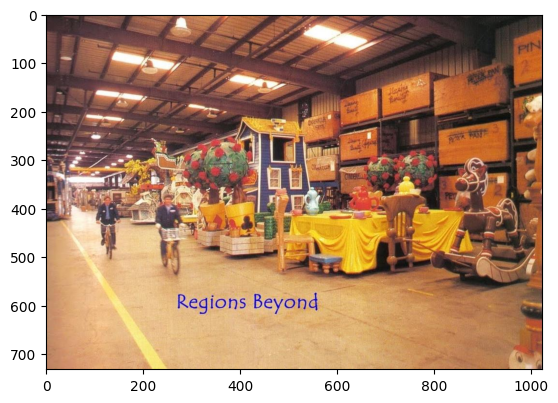

In [9]:
plt.imshow(mpimg.imread(ROOT + "widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_1014.jpg"))
plt.plot()

### Explore Distribution over number of faces

In [7]:
dist_num_faces = defaultdict(int)
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    if len(line.split(" ")) == 1 and len(line.split(".")) == 1:
      dist_num_faces[int(line)] += 1
print(dist_num_faces)

defaultdict(<class 'int'>, {1: 4631, 21: 82, 9: 244, 35: 28, 18: 106, 65: 8, 40: 30, 6: 440, 12: 169, 25: 46, 121: 4, 20: 73, 30: 40, 22: 74, 418: 1, 80: 7, 2: 1793, 13: 156, 27: 54, 54: 12, 119: 3, 11: 201, 7: 341, 24: 56, 17: 111, 58: 11, 37: 31, 174: 2, 19: 90, 3: 827, 88: 4, 36: 28, 394: 1, 10: 211, 51: 11, 15: 129, 14: 162, 4: 680, 33: 34, 100: 3, 5: 504, 52: 13, 64: 11, 67: 6, 48: 10, 41: 31, 99: 4, 32: 35, 69: 7, 28: 54, 167: 2, 73: 10, 44: 8, 16: 115, 90: 5, 188: 1, 8: 302, 238: 1, 23: 57, 31: 45, 50: 16, 46: 16, 135: 2, 45: 16, 42: 11, 333: 1, 63: 10, 26: 58, 29: 44, 77: 6, 152: 1, 91: 3, 179: 1, 143: 3, 43: 17, 222: 1, 97: 5, 126: 5, 61: 5, 234: 2, 120: 2, 98: 3, 68: 9, 53: 14, 405: 1, 38: 22, 83: 5, 0: 4, 39: 22, 113: 3, 118: 3, 34: 25, 95: 3, 272: 1, 66: 10, 223: 1, 62: 13, 116: 3, 59: 5, 92: 5, 211: 1, 78: 4, 180: 4, 129: 3, 151: 3, 56: 10, 173: 1, 811: 1, 470: 1, 215: 1, 114: 4, 49: 17, 89: 2, 86: 5, 74: 5, 60: 8, 217: 3, 153: 2, 883: 1, 131: 1, 47: 16, 147: 3, 55: 6, 75:

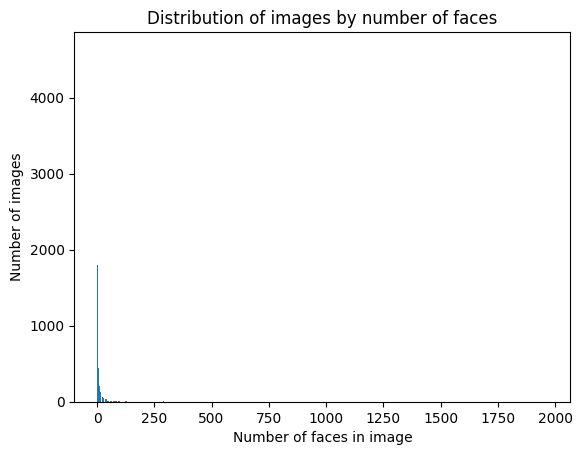

In [11]:
num_faces = list(dist_num_faces.keys())
frequency = list(dist_num_faces.values())

plt.bar(num_faces, frequency)
plt.xlabel('Number of faces in image')
plt.ylabel('Number of images')
plt.title('Distribution of images by number of faces')

plt.show()

In [15]:
print(max(frequency))
print(max(num_faces))

4631
1968


#### Scale axes logarithmic to better handle the extreme values

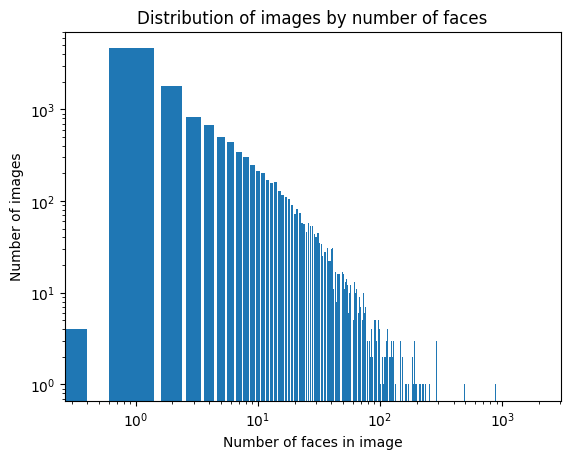

In [16]:
plt.bar(num_faces, frequency)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of faces in image')
plt.ylabel('Number of images')
plt.title('Distribution of images by number of faces')

plt.show()

## Build Data Loaders